handle text features 

- tfidf + tsvd 
- binarize tfidf + tsvd 
- hashing + tsvd 
- binarize + tsvd 

some notes : 
- constraint on ngram=(1,2), max_features = 10^5
- tsvd to dim =5 

In [38]:
import pandas as pd 
import numpy as np 
import re


In [2]:
%%time
df_train = pd.read_pickle('../input/train.pkl')
df_test = pd.read_pickle('../input/test.pkl')

Wall time: 8.16 s


In [3]:
df_train.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'param_1', 'param_2', 'param_3', 'title',
       'description', 'price', 'item_seq_number', 'activation_date',
       'user_type', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

In [16]:
## copy from https://www.kaggle.com/demery/lightgbm-with-ridge-feature/code#L72-L81
def cleanName(text):
    try:
        textProc = text.lower()
        textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        regex = re.compile(u'[^[:alpha:]]')
        textProc = regex.sub(" ", textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"

In [20]:
df_train['title'] = df_train.title.apply(lambda x: cleanName(x))
df_test['title']  = df_test.title.apply(lambda x: cleanName(x))
df_train['description'] = df_train.description.apply(lambda x:cleanName(x))
df_test['description'] = df_test.description.apply(lambda x:cleanName(x))

In [21]:
title_text_raw = df_train.title.append(df_test.title)
title_text_raw.reset_index(drop=True,inplace=True)

In [22]:
title_text_raw.shape

(2011862,)

##### tfidf + tsvd

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords 
import nltk

In [30]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [39]:
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [31]:
## copy from https://www.kaggle.com/demery/lightgbm-with-ridge-feature/code#L159-L172

russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


In [32]:
## tfidf 
tv = TfidfVectorizer(lowercase=False,ngram_range=(1,2),max_features=100000,**tfidf_para)
tv_feats = tv.fit_transform(title_text_raw)
print('shape of tfidf Vectorizer:{}'.format(tv_feats.shape))

shape of tfidf Vectorizer:(2011862, 100000)


In [33]:
svd = TruncatedSVD(n_components=5, random_state=0)
tv_svd_feats = svd.fit_transform(tv_feats)
print('shape of tv_svd_feats:',tv_svd_feats.shape)

shape of tv_svd_feats: (2011862, 5)


In [34]:
# print(svd.explained_variance_ratio_)
print(np.cumsum(svd.explained_variance_ratio_)) ## 4% variance ratio only

[ 0.01258035  0.02210309  0.02832564  0.03402659  0.03861157]


In [35]:
tv_svd_df = pd.DataFrame(tv_svd_feats).iloc[:df_train.shape[0]]
tv_svd_df['y'] = df_train.deal_probability

tv_svd_df.corr()['y']

0   -0.069581
1    0.024893
2   -0.046787
3   -0.043539
4   -0.029061
y    1.000000
Name: y, dtype: float64

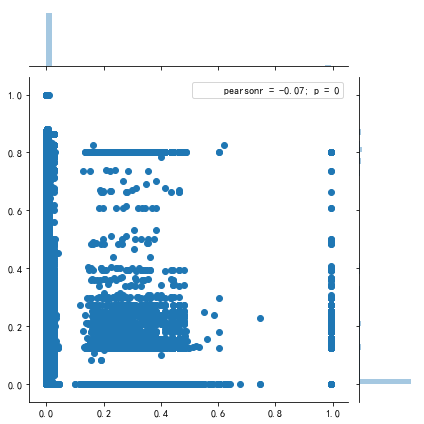

In [40]:
sns.jointplot(x = tv_svd_df[0].values, y=tv_svd_df['y'].values)

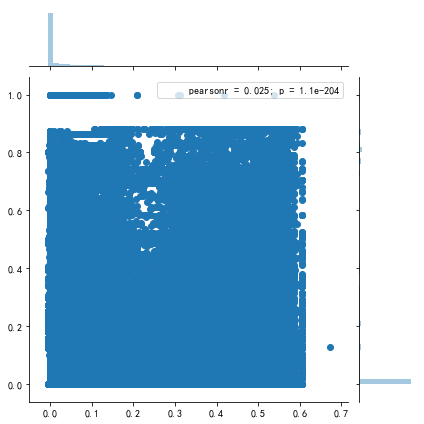

In [41]:
sns.jointplot(x = tv_svd_df[1].values, y=tv_svd_df['y'].values)

##### hashing + tsvd (title)

In [42]:
from sklearn.feature_extraction.text import HashingVectorizer

hv = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
hv_features = hv.fit_transform(title_text_raw).tocsr()
print('shape of hv features:{}'.format(hv_features.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
hv_svd_features = svd.fit_transform(hv_features)


shape of hv features:(2011862, 1048576)


In [47]:
np.cumsum(svd.explained_variance_ratio_) # 7.2%

array([ 0.02535947,  0.04120639,  0.05283315,  0.0623459 ,  0.07225276])

In [44]:
hv_svd_df = pd.DataFrame(hv_svd_features).iloc[:df_train.shape[0]]
hv_svd_df['y'] = df_train.deal_probability


In [45]:
hv_svd_df.corr().y

0    0.010421
1   -0.080351
2   -0.034651
3   -0.027230
4    0.045767
y    1.000000
Name: y, dtype: float64

______
do the same thing in description

In [46]:
desc_raw = df_train.description.append(df_test.description)
desc_raw.fillna('',inplace=True)
desc_raw.reset_index(drop=True,inplace=True)

In [48]:
## tfidf  + svd 
tv = TfidfVectorizer(lowercase=False,ngram_range=(1,2),max_features=100000,**tfidf_para)
tv_feats = tv.fit_transform(desc_raw)

print('shape of tfidf Vectorizer:{}'.format(tv_feats.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
tv_svd_feats1 = svd.fit_transform(tv_feats)
print('shape of tv_svd_feats:',tv_svd_feats.shape)

shape of tfidf Vectorizer:(2011862, 100000)
shape of tv_svd_feats: (2011862, 5)


In [49]:
svd.explained_variance_ratio_

array([ 0.05495604,  0.00722424,  0.00540837,  0.00355453,  0.00311933])

In [50]:
## hashing + svd 

hv = HashingVectorizer(ngram_range=(1, 2), lowercase=False)
hv_features = hv.fit_transform(desc_raw).tocsr()
print('shape of hv features:{}'.format(hv_features.shape))

svd = TruncatedSVD(n_components=5, random_state=0)
hv_svd_features1 = svd.fit_transform(hv_features)


shape of hv features:(2011862, 1048576)


In [51]:
hv_svd_features1.shape
tv_svd_feats1.shape

(2011862, 5)

### save hdf5

In [52]:
all_text_feats =  np.concatenate([tv_svd_feats,hv_svd_features,tv_svd_feats1,hv_svd_features1],axis=1)

In [53]:
df_text_feats = pd.DataFrame(all_text_feats)
colnames = ['title_tfidf_{}'.format(e) for e in range(5)] + ['title_hash_{}'.format(i) for i in range(5)] + \
            ['desc_tfidf_{}'.format(e) for e in range(5)] + ['desc_hash_{}'.format(i) for i in range(5)] 
df_text_feats.columns = colnames

In [54]:
df_text_feats.head().T

,0,1,2,3,4
title_tfidf_0,3.155934e-06,2.005842e-05,9.995545e-06,5.558904e-05,-3.539002e-06
title_tfidf_1,8.473049e-06,1.133695e-04,1.629503e-04,3.003903e-04,8.301491e-05
title_tfidf_2,1.255557e-05,7.503002e-05,1.882395e-05,2.437480e-05,8.447903e-05
title_tfidf_3,1.057398e-05,4.090452e-05,7.641594e-05,1.652462e-04,2.656529e-04
title_tfidf_4,5.858756e-06,1.590256e-05,7.149039e-05,-4.580733e-05,8.570438e-05
title_hash_0,4.894437e-04,6.017932e-04,1.424015e-05,2.587222e-05,2.567360e-06
title_hash_1,2.333327e-02,2.780037e-02,4.522878e-05,1.614659e-04,-7.717952e-06
title_hash_2,3.659733e-02,4.402271e-02,1.751792e-04,2.623710e-04,7.541814e-05
title_hash_3,2.834564e-01,3.382862e-01,4.820311e-04,1.199343e-03,1.405320e-04
title_hash_4,-1.910312e-01,-2.278477e-01,1.803965e-04,1.410686e-03,1.864875e-04


In [55]:
def downcast(df):
    for idx, col in enumerate(df):
        if df.iloc[:,idx].dtypes == 'float64':
            df[col] = df[col].astype('float32')
        else:
            pass    

In [57]:
downcast(df_text_feats)

In [58]:
df_text_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011862 entries, 0 to 2011861
Data columns (total 20 columns):
title_tfidf_0    float32
title_tfidf_1    float32
title_tfidf_2    float32
title_tfidf_3    float32
title_tfidf_4    float32
title_hash_0     float32
title_hash_1     float32
title_hash_2     float32
title_hash_3     float32
title_hash_4     float32
desc_tfidf_0     float32
desc_tfidf_1     float32
desc_tfidf_2     float32
desc_tfidf_3     float32
desc_tfidf_4     float32
desc_hash_0      float32
desc_hash_1      float32
desc_hash_2      float32
desc_hash_3      float32
desc_hash_4      float32
dtypes: float32(20)
memory usage: 153.5 MB


In [59]:
df_text_feats.shape

(2011862, 20)

In [60]:
len_trn = df_train.shape[0]

In [61]:
store = pd.HDFStore('../input/feats/txt_td_tfidf_hash5.h5')
store['df_trn_text_feat'] = df_text_feats.iloc[:len_trn,:]
store['df_test_text_feat'] = df_text_feats.iloc[len_trn:,:]
store.close()